# ASUM

In [166]:
import re
import json

import numpy as np
import pandas as pd

from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt

from reviews.config import (
    processed_data_dir,
    asum_model_path,
    asum_input_dir,
    asum_output_dir,
    data_dir,
)
from reviews.utils import flat_sentence_tokens
from reviews.models import ASUM

## Generate Input Data

In [168]:
NORM = "stemming"  # stemming, lemmatization
FIELD = "text"  # text, text+summary

In [163]:
# load tokens
reviews_df = pd.read_json(processed_data_dir / f"reviews_{FIELD}_{NORM}.json.gz")

In [164]:
# vocabulary
tokens = flat_sentence_tokens(reviews_df["tokens"])
vocabulary = dict((e, i) for i, e in enumerate(set(tokens)))

vocabs = set(vocabulary.keys())

with open(asum_input_dir / "WordList.txt", "w") as f:
    f.write("\n".join(vocabs))

In [165]:
# docs
with open(asum_input_dir / "BagOfSentences.txt", "w") as f:
    lines = []
    for doc in reviews_df["tokens"]:
        n = len(doc)
        lines.append(str(n))

        for tokens in doc:
            indexes = " ".join([str(vocabulary[t]) for t in tokens])
            lines.append(indexes)

    f.write("\n".join(lines))

In [169]:
# sentiment words
with open(data_dir / "sentiwords.json", "r") as f:
    senti_words = json.load(f)

    normalized = senti_words[NORM]

    pos_words = normalized["positive"]
    neg_words = normalized["negative"]

with open(data_dir / "asum" / "SentiWords-0.txt", "w") as f:
    f.write("\n".join(pos_words))

with open(data_dir / "asum" / "SentiWords-1.txt", "w") as f:
    f.write("\n".join(neg_words))

## Run

In [8]:
n_topics = 70
iterations = 1000

alpha = 0.1  # 50 / n_topics # 0.1
beta = [0.001, 0.1, 0]
gamma = [1, 1]

In [ ]:
model = ASUM(asum_model_path, asum_input_dir, asum_output_dir)
model.estimate(alpha, beta, gamma, n_topics, iterations)

## Analysis

In [13]:
filename_prefix = f"STO2-T{n_topics}-S2(2)-A{alpha}-B{','.join([f'{float(x)}' for x in beta])}-G{','.join([f'{float(x):.1f}' for x in gamma])}-I{iterations}"

In [52]:
df = pd.read_csv(asum_output_dir / f"{filename_prefix}-ProbWords.csv")


def map_topic_sentiment(column_name):
    if "Unnamed" in column_name:
        return None

    values = column_name.split("-")
    return {
        "sentiment": int(values[0][1]),
        "topic": int(values[1][1:]),
        "colname": column_name,
    }


columns = df.columns.map(map_topic_sentiment)
columns

Index([{'sentiment': 0, 'topic': 0, 'colname': 'S0-T0'},
       {'sentiment': 0, 'topic': 1, 'colname': 'S0-T1'},
       {'sentiment': 0, 'topic': 2, 'colname': 'S0-T2'},
       {'sentiment': 0, 'topic': 3, 'colname': 'S0-T3'},
       {'sentiment': 0, 'topic': 4, 'colname': 'S0-T4'},
       {'sentiment': 1, 'topic': 0, 'colname': 'S1-T0'},
       {'sentiment': 1, 'topic': 1, 'colname': 'S1-T1'},
       {'sentiment': 1, 'topic': 2, 'colname': 'S1-T2'},
       {'sentiment': 1, 'topic': 3, 'colname': 'S1-T3'},
       {'sentiment': 1, 'topic': 4, 'colname': 'S1-T4'},
                                                   None],
      dtype='object')

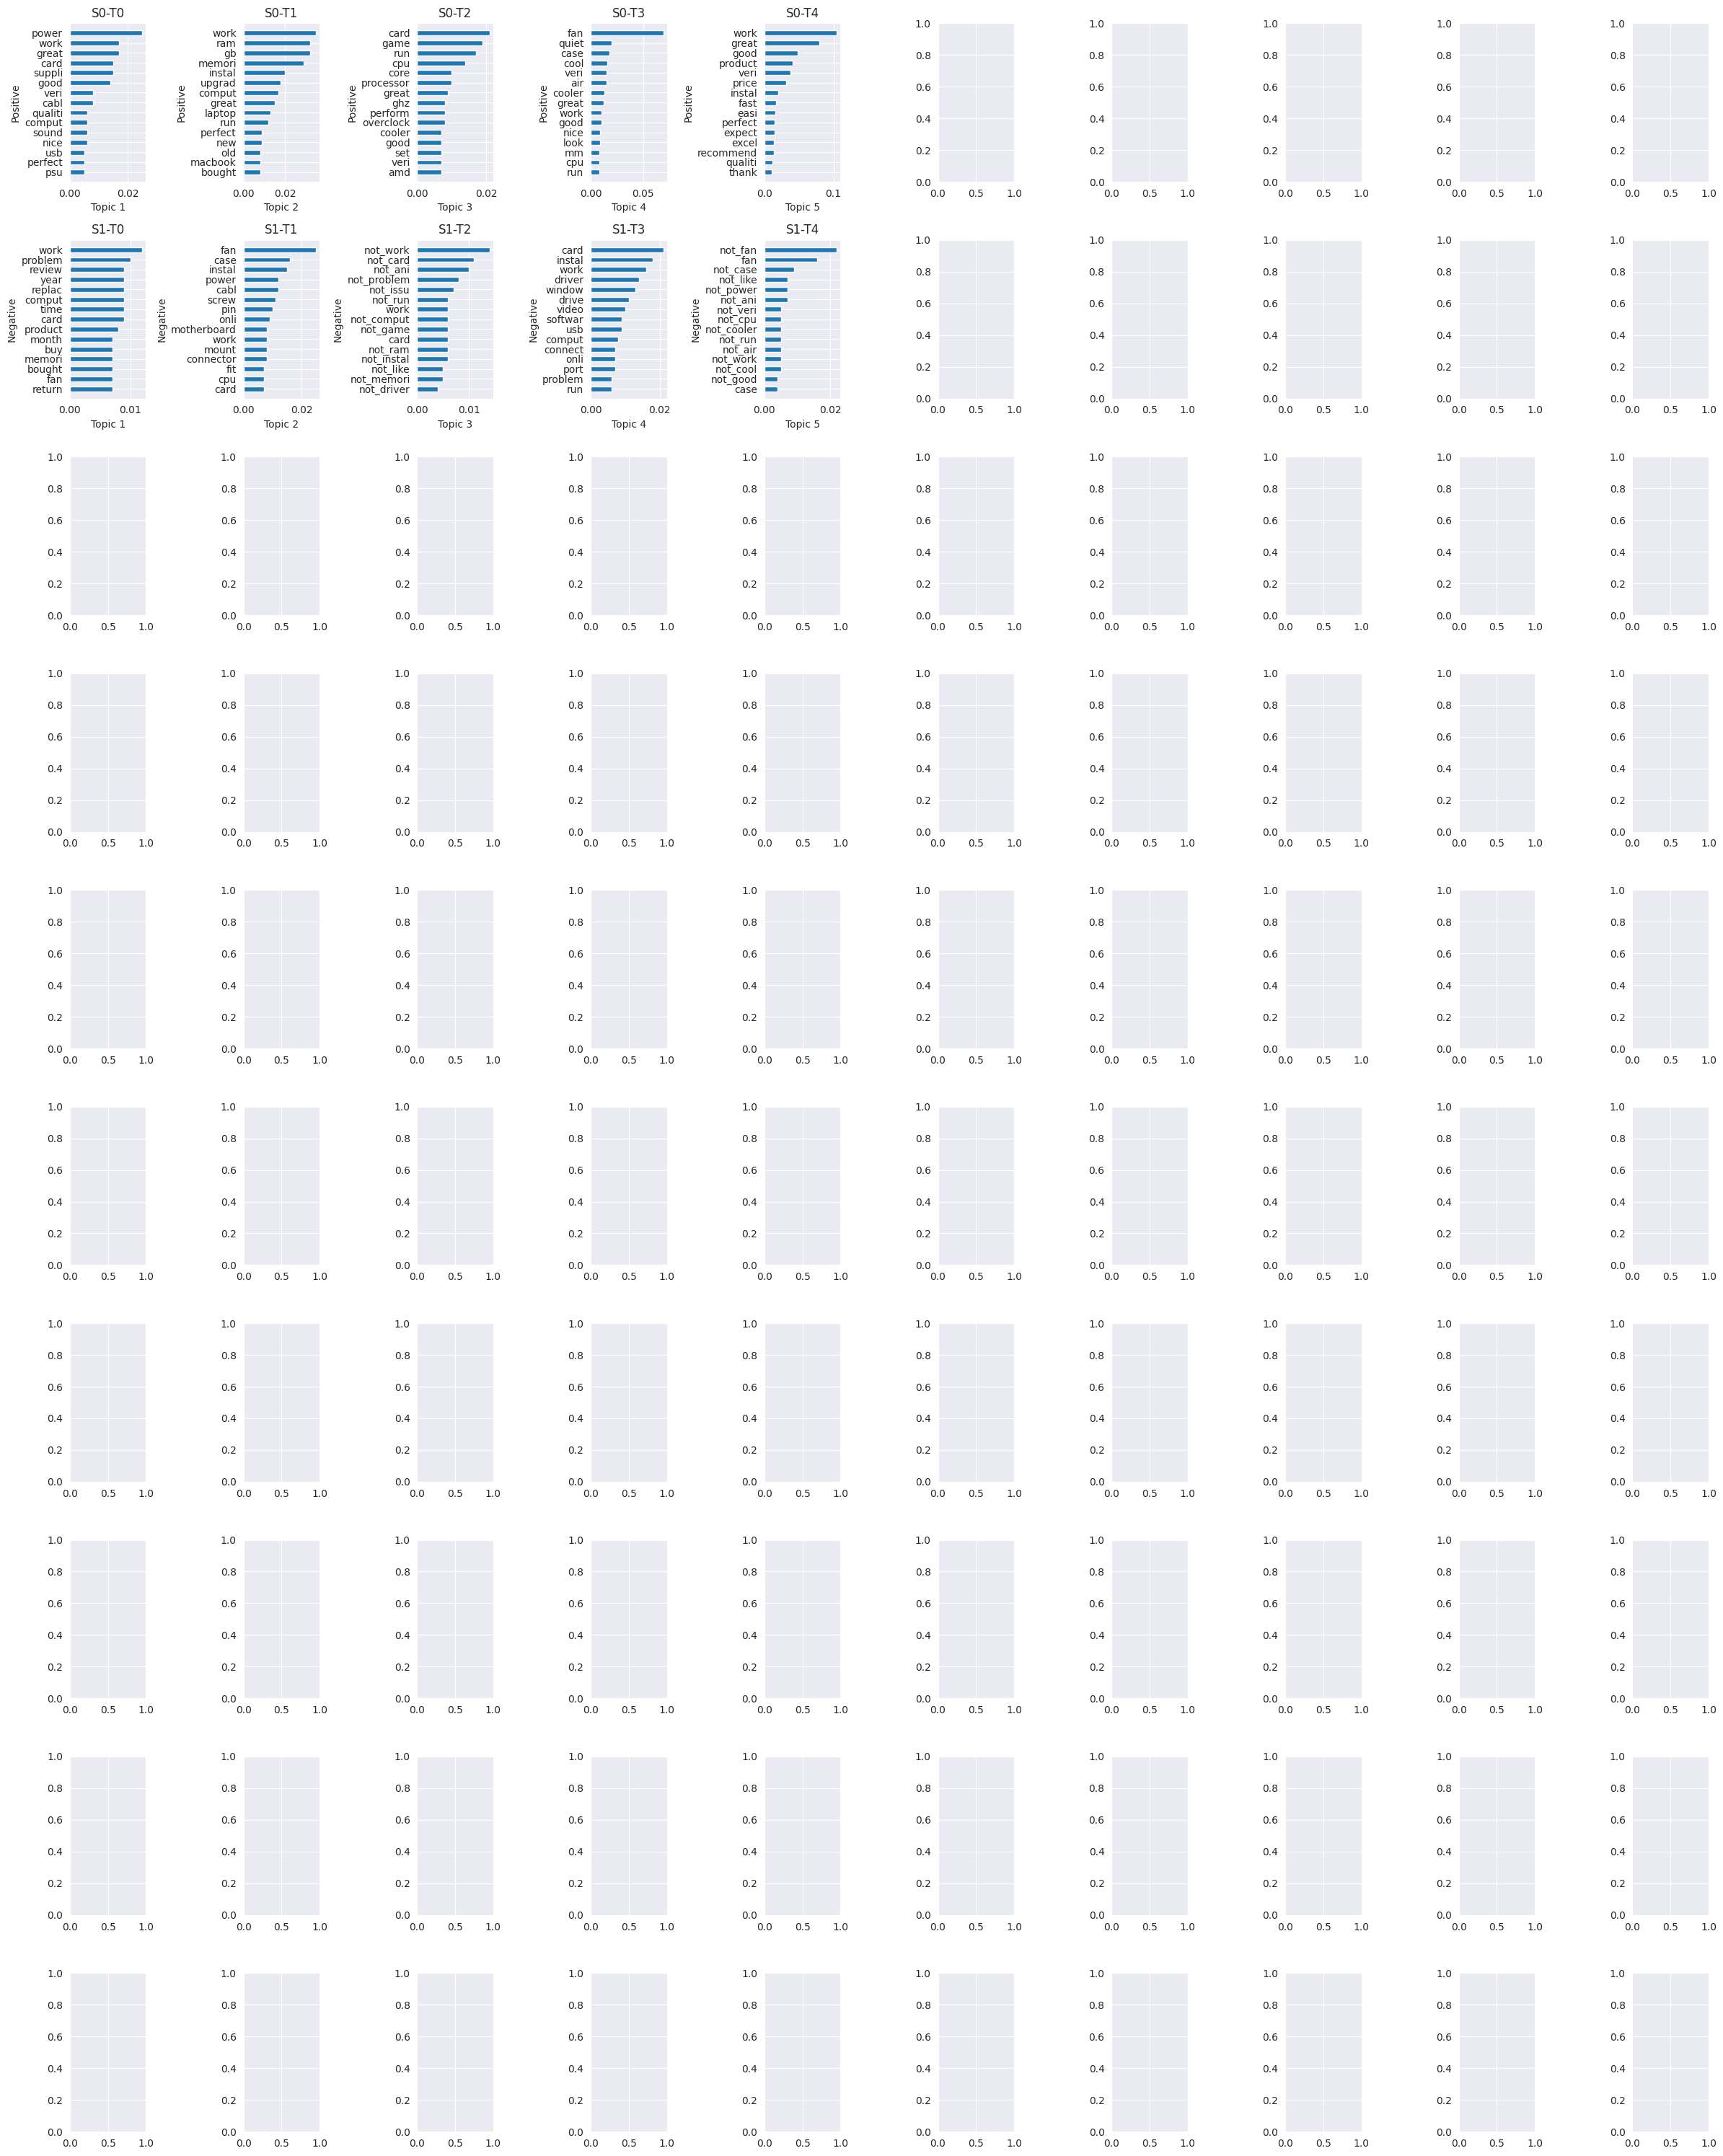

In [53]:
def get_word_weight(text):
    match = re.match("(\w+)\s+\((.*?)\)", text)
    word, weight = match.groups()
    return word, float(weight)


n_topics = 50
n_top_words = 15

total_df = pd.DataFrame()

fig, axes = plt.subplots(int(n_topics / 10 * 2), 10, figsize=(24, 30))

for idx, item in enumerate(columns):
    if item is None:
        continue

    ax = axes[
        int(int(item["topic"] / 10) * 2 + item["sentiment"]), int(item["topic"] % 10)
    ]
    words = df[item["colname"]][:n_top_words]
    weights = list(map(list, zip(*words.map(get_word_weight))))

    weights = pd.DataFrame({"names": weights[0], "weights": weights[1]})
    weights.sort_values("weights", inplace=True)

    w = weights.copy()
    w["colname"] = item["colname"]
    total_df = pd.concat((total_df, w))

    ax.barh(weights["names"], weights["weights"], height=0.5)
    ax.set_title(item["colname"])

    # if idx > n_topics - 1:
    ax.set_xlabel(f"Topic {item['topic'] + 1}")

    # if idx == 0 or idx == n_topics:
    # if int(int(item["topic"] / 10) * 2 + item["sentiment"]) % 2 == 0:
    ax.set_ylabel("Positive" if item["sentiment"] == 0 else "Negative")

fig.tight_layout()

In [54]:
# create embeddings

vocab = list(total_df["names"].unique())
word_weights = total_df.groupby("colname")[["names", "weights"]].apply(
    lambda x: dict(zip(x["names"], x["weights"]))
)
word_weights = word_weights.reset_index()


def get_embedding(weights, vocab):
    return np.array([weights.get(v, 0) for v in vocab])


embeddings = {
    ww["colname"]: get_embedding(ww[0], vocab) for i, ww in word_weights.iterrows()
}

In [55]:
# from sklearn.cluster import AgglomerativeClustering
#
# k = AgglomerativeClustering(affinity="cosine", linkage="complete", n_clusters=None, distance_threshold=0.9)
# k.fit(list(embeddings.values()))
#
# clusters = list(zip(list(embeddings.keys()), list(k.labels_)))
# clusters = pd.DataFrame(clusters, columns=["colname", "cluster"])
# clusters.groupby("cluster")["colname"].aggregate(list)

<AxesSubplot: xlabel='value', ylabel='word'>

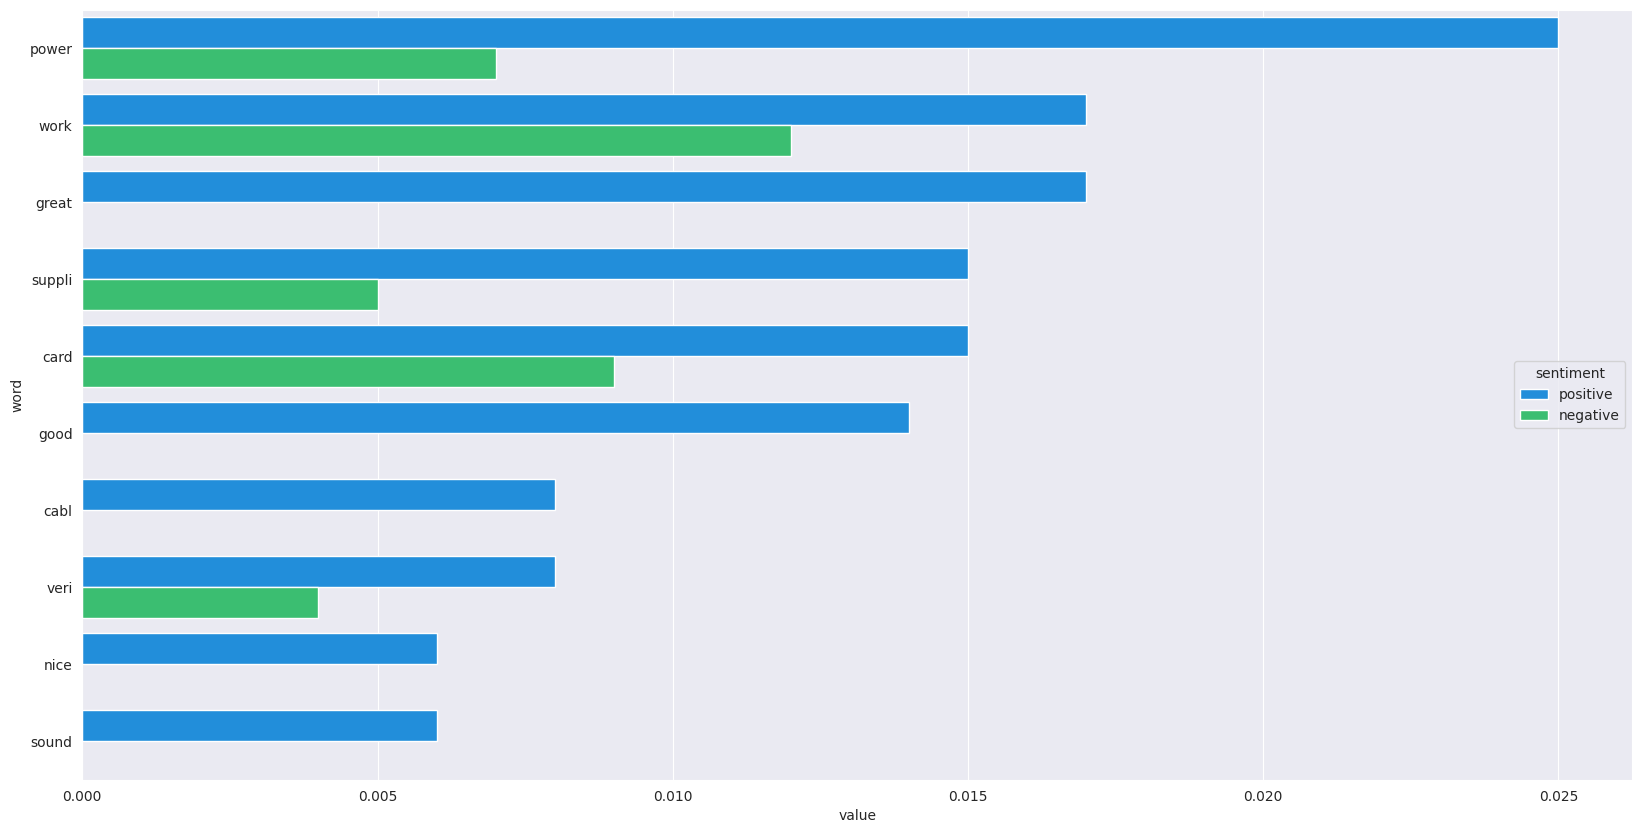

In [56]:
import seaborn as sns

df1 = pd.DataFrame(
    list(df["S0-T0"].apply(get_word_weight)), columns=["word", "positive"]
)
df2 = pd.DataFrame(
    list(df["S1-T0"].apply(get_word_weight)), columns=["word", "negative"]
)

df_tot = pd.merge(df1, df2, on="word", how="left")
df_tot.sort_values(by="positive", ascending=False, inplace=True)
df_tot = df_tot[:10]

df_tot.set_index("word", inplace=True)
df_tot = df_tot.rename_axis(columns=["sentiment"]).stack().rename("value")
df_tot = df_tot.reset_index()

df_tot.sort_values(by="value", ascending=False, inplace=True)
df_tot = df_tot[:20]

fig = plt.figure(figsize=(20, 10))
sns.barplot(
    y=df_tot["word"],
    x=df_tot["value"],
    hue=df_tot["sentiment"],
    dodge=True,
    palette=sns.color_palette("terrain"),
)

<AxesSubplot: ylabel='sentiment'>

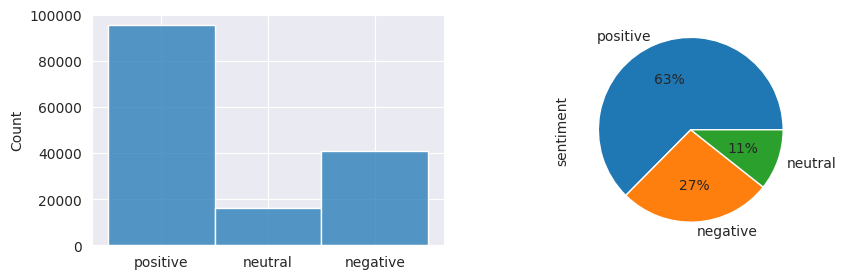

In [14]:
from matplotlib import colors
import seaborn as sns

pi_df = pd.read_csv(asum_output_dir / f"{filename_prefix}-Pi.csv", header=None)

doc_sentiment = pi_df.idxmax(axis=1).map(lambda x: "positive" if x == 0 else "negative")
doc_sentiment.loc[pi_df[0] == 0.5] = "neutral"

reviews_df["sentiment"] = doc_sentiment

fig, axes = plt.subplots(1, 2, figsize=(10, 3))
sns.histplot(x=doc_sentiment, ax=axes[0])

counts = doc_sentiment.value_counts()
counts.plot(
    ax=axes[1],
    kind="pie",
    ylabel="sentiment",
    # colors=sns.color_palette("pastel")[0:7],
    autopct="%.0f%%",
)

In [58]:
theta_df = pd.read_csv(asum_output_dir / f"{filename_prefix}-Theta.csv")
theta_df.drop(columns=[f"Unnamed: {n_topics * 2}"], inplace=True)

mask = theta_df >= 0.01
mask = mask.apply(lambda x: list(mask.columns[x]), axis=1)

reviews_df["topics"] = mask.apply(lambda x: list(map(map_topic_sentiment, x)))

KeyError: "['Unnamed: 100'] not found in axis"

In [ ]:
reviews_df.to_json(asum_output_dir / "topics.json", orient="records")

In [ ]:
phi_df = pd.read_csv(asum_output_dir / f"{filename_prefix}-Phi.csv")
phi_df.sort_values(by="S1-T1", ascending=False, inplace=True)
phi_df

### WordClouds by Topic
- most common words per topic (positive, negative)

In [ ]:
wc = WordCloud(height=400, width=800)
wc.generate_from_frequencies(
    dict(zip(phi_df["Unnamed: 0"].values, phi_df["S0-T4"].values))
)
wc.to_image()

In [ ]:
wc.generate_from_frequencies(
    dict(zip(phi_df["Unnamed: 0"].values, phi_df["S1-T4"].values))
)
wc.to_image()

In [ ]:
theta_df

In [ ]:
pi_df

In [ ]:
phi_df.sort_values("S1-T1", ascending=False)

In [ ]:
from scipy.spatial.distance import cosine

nuova_lista = []
for t1 in range(0, n_topics):
    col1 = f"S0-T{t1}"
    for t2 in range(0, n_topics):
        if t1 <= t2:
            col2 = f"S1-T{t2}"
            c = cosine(phi_df[col1], phi_df[col2])
            if c > 0.99:
                print(col1, col2, c)
                nuova_lista.append((col1, col2))

                min1 = phi_df[col1].sort_values(ascending=False)[:30].min()
                min2 = phi_df[col2].sort_values(ascending=False)[:30].min()
                min_prob = 0.001  # min(min1, min2)
                print(min_prob)

                cond1 = phi_df[col1] >= min_prob
                cond2 = phi_df[col2] >= min_prob

                print(
                    "Common:", ", ".join(list(phi_df.loc[cond1 & cond2]["Unnamed: 0"]))
                )
                print(
                    "Positive:",
                    ", ".join(list(phi_df.loc[cond1 & (~cond2)]["Unnamed: 0"])),
                )
                print(
                    "Negative:",
                    ", ".join(list(phi_df.loc[(~cond1) & cond2]["Unnamed: 0"])),
                )
                print("\n")

In [ ]:
nuova_lista

In [ ]:
total_df

In [ ]:
count = Counter()

for x in reviews_df["topics"].values:
    topics = set(["T" + str(y["topic"]) for y in x])
    count.update(topics)

topics_count = pd.DataFrame(count.items(), columns=["topic", "count"])
topics_count["topic"] = topics_count["topic"].astype("category")

order = topics_count.sort_values(by="count", ascending=False).topic
fig = plt.figure(figsize=(8, 5))
ax = sns.barplot(
    y=topics_count["topic"], x=topics_count["count"], order=order, orient="h"
)
ax.set_title("Topics")
fig.tight_layout()

#### Filtrare i topic-sentiment classificando il sentiment

- T1-S0: 34, T1-S1: 56 ---> S1
- T1-S0: 74, T1-S1: 21 ---> S0
- T1-S0: 67, T1-S1: 67 ---> S2 (neutral?)

In [ ]:
from matplotlib.pyplot import title

pos_count = Counter()
neg_count = Counter()

for x in reviews_df["topics"].values:
    pos_topics = set(["T" + str(st["topic"]) for st in x if st["sentiment"] == 0])
    neg_topics = set(["T" + str(st["topic"]) for st in x if st["sentiment"] == 1])

    pos_count.update(pos_topics)
    neg_count.update(neg_topics)

pos_df = pd.DataFrame(pos_count.items(), columns=["topic", "pos"])
neg_df = pd.DataFrame(neg_count.items(), columns=["topic", "neg"])

st_counts = pd.merge(pos_df, neg_df, on="topic")
st_counts["topic"] = st_counts["topic"].astype("category")

total = st_counts["pos"] + st_counts["neg"]
st_counts["pos"] = st_counts["pos"] / total * 100
st_counts["neg"] = st_counts["neg"] / total * 100

st_counts.set_index("topic", inplace=True)
st_counts.sort_index(inplace=True)
st_counts = st_counts.iloc[[int(o[1]) for o in order][::-1]]

fig, ax = plt.subplots(figsize=(10, 7))
st_counts.plot(
    kind="barh", stacked=True, color=["red", "green"], ax=ax, title="Topics Sentiment"
)

pass

### topic sentiment over time

In [ ]:
timestamps = list(set(reviews_df["timestamp"]))  # discretizzare per anni
count = Counter()

for x in reviews_df["topics"].values:
    for t in timestamps:
        topics = set(["T" + str(y["topic"]) + str(t) for y in x])
        count.update(topics)

topics_count = pd.DataFrame(count.items(), columns=["topic", "count"])

In [ ]:
len(timestamps)

### positive sentiment over time

In [ ]:
X = reviews_df.copy()
X = X.loc[X["sentiment"] == "positive"]
fig = plt.figure(figsize=(20, 4))
sns.histplot(x=X["timestamp"], hue=X["sentiment"])

### negative sentiment over time

In [ ]:
X = reviews_df.copy()
X = X.loc[X["sentiment"] == "negative"]
fig = plt.figure(figsize=(20, 4))
sns.histplot(x=X["timestamp"], hue=X["sentiment"])

### top 30 brands sentiment 

In [ ]:
X = reviews_df.copy()

# take only top 30 most common brands
most_common_brands = pd.DataFrame(Counter(X["brand"]).most_common(30))
X = X.loc[X["brand"].isin(set(most_common_brands[0]))]

fig, ax = plt.subplots(figsize=(20, 7))

x = (
    X.groupby("brand")["sentiment"]
    .value_counts()
    .rename_axis(["brand", "polarity"])
    .reset_index()
    .pivot(columns="polarity", index="brand", values="sentiment")
)

# normalize
total = x["neutral"] + x["negative"] + x["positive"]
x["neutral"] = x["neutral"] / total * 100
x["negative"] = x["negative"] / total * 100
x["positive"] = x["positive"] / total * 100

x.reset_index(inplace=True)

x.plot(x="brand", kind="bar", stacked=True, ax=ax)
fig.tight_layout()

### sentiment per category 

In [ ]:
X = reviews_df.copy()

fig, ax = plt.subplots(figsize=(20, 7))

x = (
    X.groupby("category")["sentiment"]
    .value_counts()
    .rename_axis(["category", "polarity"])
    .reset_index()
    .pivot(columns="polarity", index="category", values="sentiment")
)

# normalize
total = x["neutral"] + x["negative"] + x["positive"]
x["neutral"] = x["neutral"] / total * 100
x["negative"] = x["negative"] / total * 100
x["positive"] = x["positive"] / total * 100

x.reset_index(inplace=True)

x.plot(x="category", kind="bar", stacked=True, ax=ax)
fig.tight_layout()

### sentiment per price

In [ ]:
X = reviews_df.copy()
price_categories = pd.CategoricalDtype(
    categories=[
        "Under \$25",
        "\$25 to \$50",
        "\$50 to \$100",
        "\$100 to \$200",
        "\$200 & Above",
    ],
    ordered=True,
)

X["price"] = X["price"].apply(
    lambda x: "Under \$25"
    if x < 25
    else (
        "\$25 to \$50"
        if x < 50
        else (
            "\$50 to \$100"
            if x < 100
            else ("\$100 to \$200" if x < 200 else "\$200 & Above")
        )
    )
)
X["price"] = X["price"].astype(price_categories)

fig, ax = plt.subplots(figsize=(10, 7))

x = (
    X.groupby("price")["sentiment"]
    .value_counts()
    .rename_axis(["price", "polarity"])
    .reset_index()
    .pivot(columns="polarity", index="price", values="sentiment")
)

# normalize
total = x["neutral"] + x["negative"] + x["positive"]
x["neutral"] = x["neutral"] / total * 100
x["negative"] = x["negative"] / total * 100
x["positive"] = x["positive"] / total * 100

x.reset_index(inplace=True)

x.plot(x="price", kind="bar", stacked=True, ax=ax)
fig.tight_layout()

### EVALUATION

In [ ]:
t = pd.crosstab(
    reviews_df["overall"].apply(
        lambda x: "negative" if x < 3 else ("neutral" if x == 3 else "positive")
    ),
    reviews_df["sentiment"].astype("category"),
)
t

### negative sentiment over time

In [ ]:
X = reviews_df.copy()
X = X.loc[X["sentiment"] == "negative"]
fig = plt.figure(figsize=(20, 4))
sns.histplot(x=X["timestamp"], hue=X["sentiment"])

### top 30 brands sentiment 

In [ ]:
X = reviews_df.copy()

# take only top 30 most common brands
most_common_brands = pd.DataFrame(Counter(X["brand"]).most_common(30))
X = X.loc[X["brand"].isin(set(most_common_brands[0]))]

fig, ax = plt.subplots(figsize=(20, 7))

x = (
    X.groupby("brand")["sentiment"]
    .value_counts()
    .rename_axis(["brand", "polarity"])
    .reset_index()
    .pivot(columns="polarity", index="brand", values="sentiment")
)

# normalize
total = x["neutral"] + x["negative"] + x["positive"]
x["neutral"] = x["neutral"] / total * 100
x["negative"] = x["negative"] / total * 100
x["positive"] = x["positive"] / total * 100

x.reset_index(inplace=True)

x.plot(x="brand", kind="bar", stacked=True, ax=ax)
fig.tight_layout()

### sentiment per category 

In [ ]:
X = reviews_df.copy()

fig, ax = plt.subplots(figsize=(20, 7))

x = (
    X.groupby("category")["sentiment"]
    .value_counts()
    .rename_axis(["category", "polarity"])
    .reset_index()
    .pivot(columns="polarity", index="category", values="sentiment")
)

# normalize
total = x["neutral"] + x["negative"] + x["positive"]
x["neutral"] = x["neutral"] / total * 100
x["negative"] = x["negative"] / total * 100
x["positive"] = x["positive"] / total * 100

x.reset_index(inplace=True)

x.plot(x="category", kind="bar", stacked=True, ax=ax)
fig.tight_layout()

### sentiment per price

In [ ]:
X = reviews_df.copy()
price_categories = pd.CategoricalDtype(
    categories=[
        "Under \$25",
        "\$25 to \$50",
        "\$50 to \$100",
        "\$100 to \$200",
        "\$200 & Above",
    ],
    ordered=True,
)

X["price"] = X["price"].apply(
    lambda x: "Under \$25"
    if x < 25
    else (
        "\$25 to \$50"
        if x < 50
        else (
            "\$50 to \$100"
            if x < 100
            else ("\$100 to \$200" if x < 200 else "\$200 & Above")
        )
    )
)
X["price"] = X["price"].astype(price_categories)

fig, ax = plt.subplots(figsize=(10, 7))

x = (
    X.groupby("price")["sentiment"]
    .value_counts()
    .rename_axis(["price", "polarity"])
    .reset_index()
    .pivot(columns="polarity", index="price", values="sentiment")
)

# normalize
total = x["neutral"] + x["negative"] + x["positive"]
x["neutral"] = x["neutral"] / total * 100
x["negative"] = x["negative"] / total * 100
x["positive"] = x["positive"] / total * 100

x.reset_index(inplace=True)

x.plot(x="price", kind="bar", stacked=True, ax=ax)
fig.tight_layout()

### EVALUATION

In [15]:
reviews_df["true"] = (
    reviews_df["overall"]
    .apply(lambda x: "negative" if x < 3 else ("neutral" if x == 3 else "positive"))
    .astype("category")
)

In [16]:
pd.crosstab(
    reviews_df["true"],
    reviews_df["sentiment"].astype("category"),
)

sentiment,negative,neutral,positive
true,,,
negative,8417,1092,2224
neutral,4090,935,2967
positive,28276,14206,90161


In [17]:
from sklearn.metrics import f1_score

f1_score(reviews_df["true"], reviews_df["sentiment"], average="weighted")

0.7172485447734465